<a href="https://colab.research.google.com/github/SeoJiWon1/Mask-detection/blob/main/Mask_Detection_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mask Detector Train

## Import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
import time
import copy

## Image_datasets / data_loader 

# 데이터셋 불러오기
# Dataset

우선 데이터셋을 먼저 살펴보면, 샘플 데이터와 레이블(label) 또는 정답 데이터를 저장하는 역할을 수행한다.

한마디로 학습(Train) 데이터셋과 학습을 통해 산출된 결과 데이터셋을 다루는 역할을 담당한다는 것이다.

PyTorch Dataset을 통해서 이미지, 텍스트, 오디오 데이터셋을 다룰 수 있다.

# Dataloader

데이터로더는 데이터셋에 접근하는 역할을 수행한다.

데이터 로더를 통해서 데이터셋에 대한 import와 export를 모두 할 수 있다.

* torch.utils.data
    * 데이터셋의 표준을 정의하고 데이터셋을 불러오고 자르고 섞는 데 쓰는 도구들이 들어있는 모습
    * 파이토치 모델을 학습시키기 위한 데이터셋의 표준을 torch.utils.data.Dataset에 정의
    * Dataset 모듈을 상속하는 파생 클래스는 학습에 필요한 데이터를 로딩해주는 torch.utils.data.DataLoader 인스턴스의 입력으로 사용할 수 있음
* torchvision.datasets
    * torch.utils.data.Dataset을 상속하는 이미지 데이터셋의 모음. 패션 아이템 데이터셋이 바로 여기에 들어있음
* torchvision.transforms
    * 이미지 데이터셋에 쓸 수 있는 여러 가지 변환 필터를 담고 있는 모듈.
    * 예를 들어 텐서로 변환한다든지, 크기 조절(resize)과 크롭(crop)으로 이미지를 수정할 수도 있고, 밝기(brightness), 대비(contrast) 등을 조절하는 데 사용될 수도 있음
* torchvision.utils
    * 이미지 데이터를 저장하고 시각화하기 위한 도구가 들어있는 모듈

## Train /  Test 이미지 폴더 불러오기

* 구글 드라이브에 이미지 zip 저장
* 구글 마운트
* unzip으로 폴더 해제

In [ ]:
!unzip /content/drive/MyDrive/DL/MASK/mask_train_test/mask_train.zip -d /content/drive/MyDrive/DL/MASK/mask_train_test

In [ ]:
!unzip /content/drive/MyDrive/DL/MASK/mask_train_test/mask_test.zip -d /content/drive/MyDrive/DL/MASK/mask_train_test

In [4]:
import os

num_train_with_mask = len(os.listdir('/content/drive/MyDrive/DL/MASK/mask_train_test/train/with_mask'))
num_train_without_mask = len(os.listdir('/content/drive/MyDrive/DL/MASK/mask_train_test/train/without_mask'))
num_train = num_train_with_mask + num_train_without_mask

num_test_with_mask = len(os.listdir('/content/drive/MyDrive/DL/MASK/mask_train_test/test/with_mask'))
num_test_without_mask = len(os.listdir('/content/drive/MyDrive/DL/MASK/mask_train_test/test/without_mask'))
num_test = num_test_with_mask + num_test_without_mask

print(f'훈련데이터 마스크포함 개수 : {num_train_with_mask}')
print(f'훈련데이터 마스크없음 개수 : {num_train_without_mask}')
print(f'시험데이터 마스크포함 개수 : {num_test_with_mask}')
print(f'시험데이터 마스크없음 개수 : {num_test_without_mask}')
print(f'훈련데이터 개수: {num_train}')
print(f'시험데이터 개수: {num_test}')

훈련데이터 마스크포함 개수 : 658
훈련데이터 마스크없음 개수 : 657
시험데이터 마스크포함 개수 : 97
시험데이터 마스크없음 개수 : 97
훈련데이터 개수: 1315
시험데이터 개수: 194


In [ ]:
# git에 있는 이미지 다운 
# https://downgit.github.io/#/home?url=https:%2F%2Fgithub.com%2Fprajnasb%2Fobservations%2Ftree%2Fmaster%2Fexperiements%2Fdest_folder%2Ftrain

In [ ]:
# 이미지를 텐서로 변환
# 토치비전의 transforms : 입력받은 이미지를 변환시키는 도구
# 기능을 추가하고 싶다 -> transforms.Compose() 함수 안의 리스트로 넣어주면 순서대로 변환
# transform = transforms.Compose([
#     transforms.ToTensor()
# ])

### Transform, feature 설정
transform || target_transform

Transforms에서 자주 쓰이는 기능
* ToTensor : 이미지를 파이토치 텐서로 변환
* Resize : 이미지 크기 조정
* Normalize : 주어진 평균과 표준편차를 이용하여 정규화
* RandomHorizontalFlip : 무작위로 이미지의 오른쪽과 왼쪽을 뒤집는 기능
* RandomCrop : 이미지를 무작위로 자르는 기능

In [5]:
# transform 설정
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]), 
    'test' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [6]:
experiments_path = '/content/drive/MyDrive/DL/MASK/mask_train_test'

In [7]:
image_datasets = {x: datasets.ImageFolder(os.path.join(experiments_path, x), data_transforms[x]) for x in ['train', 'test']}

In [8]:
image_datasets['train']

Dataset ImageFolder
    Number of datapoints: 1315
    Root location: /content/drive/MyDrive/DL/MASK/mask_train_test/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear), antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [9]:
image_datasets['test']

Dataset ImageFolder
    Number of datapoints: 194
    Root location: /content/drive/MyDrive/DL/MASK/mask_train_test/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

DataLoader 설정

In [10]:
from torch.utils.data import DataLoader

In [11]:
# torch.utils.data.DataLoader 인스턴스의 입력으로 사용할 수 있음

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                             batch_size=16, 
                                             shuffle=True, 
                                             num_workers=4) 
               for x in ['train', 'test']}

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [12]:
dataloaders 

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fe8c62a77f0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fe8c6292580>}

## 환경설정

In [13]:
# GPU 사용 환경

torch.cuda.is_available() # 현재 컴퓨터(머신)에서 CUDA(GPU)를 사용할 수 있는지 확인
# 런타임 > 런타임 유형 변경 > 하드웨어 가속기 > GPU

True

In [14]:
# 환경에 따라서 CPU / GPU 를 알아서 설정하게 하는 코드
USE_CUDA = torch.cuda.is_available()
USE_CUDA

True

In [15]:
# USE_CUDA가 True면 cuda를 입력해서, GPU 장치를 사용하고, 아니면 CPU를 쓰겠다
DEVICE = torch.device("cuda"if USE_CUDA else "cpu")
DEVICE

device(type='cuda')

In [16]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

In [17]:
dataset_sizes

{'train': 1315, 'test': 194}

In [21]:
class_names = image_datasets['train'].classes

In [22]:
class_names

['with_mask', 'without_mask']

## Visualizing images

In [18]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20,20))
    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    

In [19]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


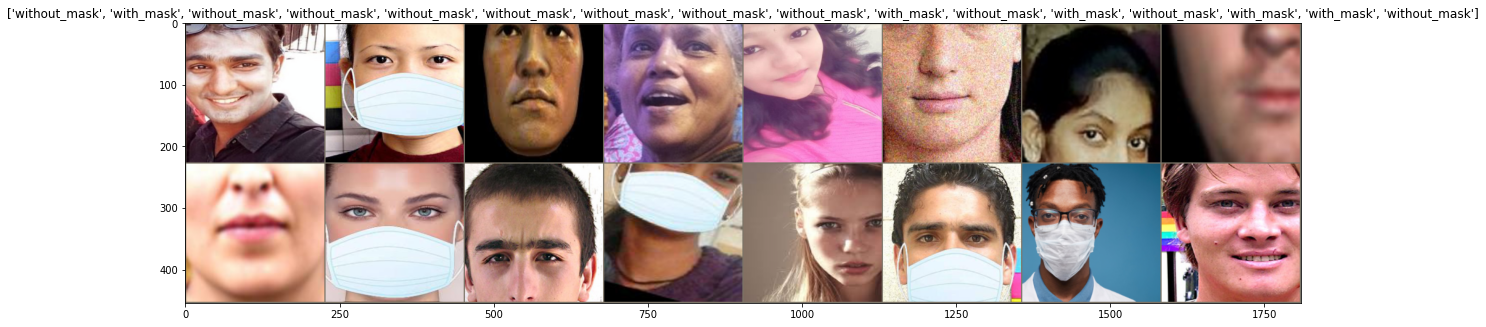

In [23]:
imshow(out, title=[class_names[x] for x in classes])

## Training Model
(손실함수, 옵티마이저 설정, 모델훈련)

### 모델훈련
https://9bow.github.io/PyTorch-tutorials-kr-0.3.1/beginner/transfer_learning_tutorial.html#id4 참조

In [32]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time() # 현재 시간을 나타냄
    best_acc = 0.0
    best_model = copy.deepcopy(model.state_dict())
    
    new_freeze_state = None
    prev_freeze_state = False
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
        
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
                
                optimizer.zero_grad()
                
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc:{:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
            
            print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model)
    return model
                

In [33]:
import ssl

In [34]:
ssl._create_default_https_context = ssl._create_unverified_context

### 손실함수, 옵티마이저 설정

In [35]:
model_ft = models.resnet101(pretrained=True)

num_frts = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_frts, len(class_names))

model_ft = model_ft.to(DEVICE)
criterion = nn.CrossEntropyLoss()

#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
optimizer_ft = optim.Adagrad(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [36]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.2027 Acc:0.9133

test Loss: 0.0017 Acc:1.0000

Epoch 1/19
----------
train Loss: 0.1032 Acc:0.9521

test Loss: 0.0005 Acc:1.0000

Epoch 2/19
----------
train Loss: 0.1164 Acc:0.9506

test Loss: 0.0025 Acc:1.0000

Epoch 3/19
----------
train Loss: 0.0880 Acc:0.9605

test Loss: 0.0019 Acc:1.0000

Epoch 4/19
----------
train Loss: 0.0790 Acc:0.9627

test Loss: 1.9689 Acc:0.6082

Epoch 5/19
----------
train Loss: 0.0967 Acc:0.9506

test Loss: 0.0018 Acc:1.0000

Epoch 6/19
----------
train Loss: 0.0669 Acc:0.9673

test Loss: 0.0018 Acc:1.0000

Epoch 7/19
----------
train Loss: 0.0771 Acc:0.9620

test Loss: 0.0016 Acc:1.0000

Epoch 8/19
----------
train Loss: 0.0615 Acc:0.9711

test Loss: 0.0020 Acc:1.0000

Epoch 9/19
----------
train Loss: 0.0596 Acc:0.9726

test Loss: 0.0021 Acc:1.0000

Epoch 10/19
----------
train Loss: 0.0656 Acc:0.9688

test Loss: 0.0015 Acc:1.0000

Epoch 11/19
----------
train Loss: 0.0675 Acc:0.9620

test Loss: 0.0010 Acc:1.0000

Epoch 12/19
----------
t

In [36]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    #fig = plt.figure(figsize=(10,10))
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print(preds,"predicitons")
            
            
            for j in range(inputs.size()[0]):
                images_so_far +=1
                #ax = plt.subplot(num_images//len(labels)-1, len(labels), images_so_far)
                #ax.axis('off')
                #ax.set_title('true: {} predicted: {}'.format(class_names[labels[j]], class_names[preds[j]]))
                print('true: {} predicted: {}'.format(class_names[labels[j]], class_names[preds[j]]))
                #imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)